AttributeError: Unknown property z

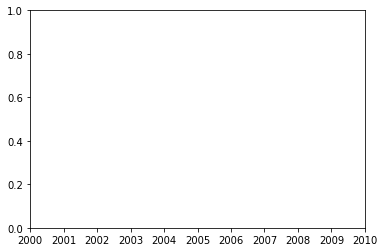

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_rows=10
df = pd.read_table("grenoble_7.k7",sep = ',',header = 0)
df.head(10)
df['datetime'] = pd.to_datetime(df['datetime'],format='%Y-%m-%d')
df=df.set_index('datetime')
df['channel'].sort_values()
#fig, ax = plt.subplots()
#df.groupby('channel').plot(x='channel',y='pdr',ax=ax, legend=False)
df.plot(y='mean_rssi')
#df.plot(grid=True)
#print("\nType de données",df.dtypes,"\n\n")
print(df['2018-01-11'])